Shows the bias and variance of MLEs using the bound sampler. Bootstrap runs are in the `bootstrap_acc` folder. Following command sends the bootstrap jobs to the slurm:
* `python bs_example_demo.py bound_sampler=True mode=send_jobs njobs=100 q=<q>`

In [2]:
import os
import jax
import optax

import demes, demesdraw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi, optax_step
from momi3.utils import bootstrap_sample

import sys
import re
import math
import pickle
import tskit

import jax.numpy as jnp

from ast import literal_eval
from tqdm.notebook import trange
from train import get_demo, get_params

from scipy import stats

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# This is where the plots are saved
dissertation_dir = '../../PhD-Dissertation/'

In [4]:
sys.path.append('..')

In [5]:
from Timing_util import add_captions

In [32]:
# Load the results of bootstrap runs

df = []

bss = [False] + 5 * [True]
qs = [None, 0.95, 0.99, 0.9975, 0.999, 1.0] # bound sampler quantiles

for q, bs in zip(qs, bss):
    for i in range(100):
        if bs:
            name = f"seed_{i}_bound_{bs}_q={q}.csv"
        else:
            name = f"seed_{i}_bound_{bs}.csv"

        with open('bootstrap_acc/' + name, 'rb') as f:
            history = pickle.load(f)
            ind = np.argmin(history['LLs'])
            ttd = history['ttds'][ind]
            ttd = {i: float(ttd[i]) for i in ttd}
            d = {'bs': bs, 'q':q, 'i':i, 'LL': float(history['LLs'][ind])} | ttd
            df.append(d)
df = pd.DataFrame(df)
df['pi_0'] = 100 * df['pi_0']
df = df.fillna('No Sampler')

In [33]:
df = df.sort_values(['q', 'i']).reset_index(drop=True)

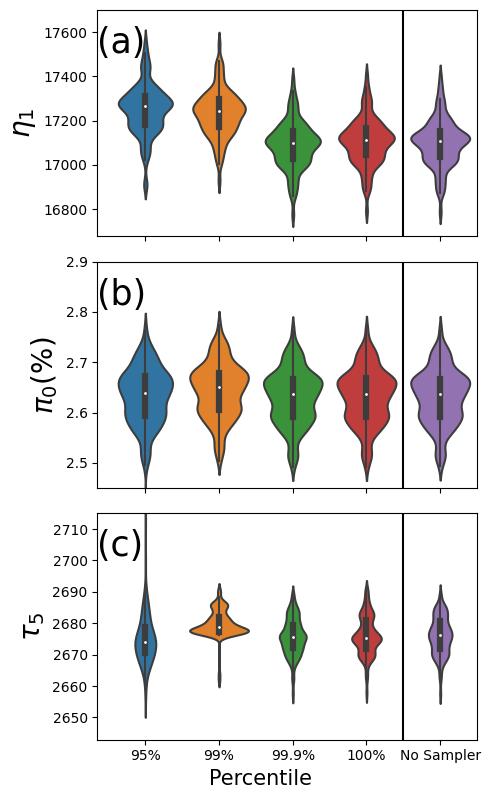

In [38]:
figure_name = 'violin_bs_estimates'

fig, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True)


bounds = {'eta_1': (None, 17700), 'pi_0': (2.45, 2.9), 'tau_5': (None, 2715)}

letters = iter(['a', 'b', 'c'])

axs = iter(axs)
for x in ['eta_1', 'pi_0', 'tau_5']:
    ax = next(axs)
    sns.violinplot(
        data=df, x="q", y=x, bw=.25,
        order=[0.95, 0.99, 0.999, 1.0, 'No Sampler'],
        showfliers=False, 
        ax=ax
    )
    if x[:2] == 'pi':
        lab = f"$\{x}$(%)"
    else:
        lab = f"$\{x}$"
    ax.set_ylim(bounds[x])
    ax.set_xlim(-0.65, None)
    ax.set_ylabel(lab, size=20)
    ax.set_xlabel(None)
    l = next(letters)
    ax.text(0., 0.81, f'({l})', transform=ax.transAxes, fontsize=25)
    ax.axvline(3.5, color='black')

plt.text(0.86, 2628.5, 'Percentile', size=15)
plt.tight_layout()
plt.xticks(range(5), ['95%', '99%', '99.9%', '100%', 'No Sampler'])

plt.savefig(f"{dissertation_dir}figures/chapter3/{figure_name}.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [39]:
for var in ['eta_1', 'pi_0', 'tau_5']:
    v = df[df['q'] == 'No Sampler'][var].to_numpy()
    df[f"APE{var}"] = df.groupby('q')[var].apply(lambda x: x-v)

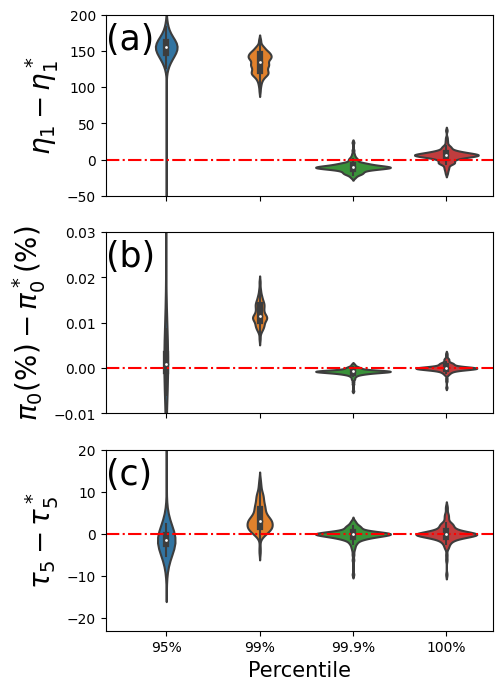

In [40]:
figure_name = 'violin_bs_bias'


fig, axs = plt.subplots(3, 1, figsize=(5, 8), sharex=True)

bounds = {'eta_1': (-50, 200), 'pi_0': (-0.01, 0.03), 'tau_5': (None, 20)}

letters = iter(['a', 'b', 'c'])

axs = iter(axs)
for x in ['eta_1', 'pi_0', 'tau_5']:
    ax = next(axs)
    sns.violinplot(
        data=df, x="q", y="APE"+x, bw=.25,
        order=[0.95, 0.99, 0.999, 1.0],
        showfliers=False, 
        ax=ax
    )
    if x[:2] == 'pi':
        lab = f"$\{x}(\%)-\{x}^*(\%)$"
    else:
        lab = f"$\{x}-\{x}^*$"
    ax.set_ylim(bounds[x])
    ax.set_ylabel(lab, size=20)
    ax.set_xlabel(None)
    ax.set_xlim(-0.65, None)
    ax.axhline(0., linestyle='-.', color='red')
    l = next(letters)
    ax.text(0., 0.81, f'({l})', transform=ax.transAxes, fontsize=25)

plt.xlabel('Percentile', fontsize=15)
plt.xticks(range(4), ['95%', '99%', '99.9%', '100%'])
plt.savefig(f"{dissertation_dir}figures/chapter3/{figure_name}.pdf", format="pdf", bbox_inches="tight", dpi=600)
plt.show()

# Effect on grad time (Timing)

## Simplified Admixture demo

In [41]:
demo = get_demo('pulse')

ddict = demo.asdict()
dem = ddict['demes']
pul = ddict['pulses']
dem[7]['ancestors'] = ['ancestral']
dem[7]['start_time'] = 12500
dem = [dem[0], dem[1], dem[2],  dem[3], dem[4], dem[7], dem[8]]
pul = [pul[0]]
ddict['demes'] = dem
ddict['pulses'] = pul
demo = demes.Builder.fromdict(ddict).resolve()

In [42]:
ts = tskit.load('/mnt/turbo/eneswork/Unified_genome/hgdp_tgp_sgdp_high_cov_ancients_chr20_p.dated.trees')
deme_ids = {'Yoruba': 64, 'French': 16, 'Vindija': 214}
sampled_demes = tuple(deme_ids)

In [43]:
sampled_demes = tuple(deme_ids)

In [44]:
samples = [ts.samples(deme_ids[pop]) for pop in sampled_demes]
jsfs = ts.allele_frequency_spectrum(samples, polarised=True, span_normalise=False)
sample_sizes = [i - 1 for i in jsfs.shape]

In [45]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True, batch_size=6835, low_memory=True)

In [46]:
params = momi._default_params
params.set_train('tau_5', True)
params.set_train('pi_0', True)
params.set_train('eta_1', True)

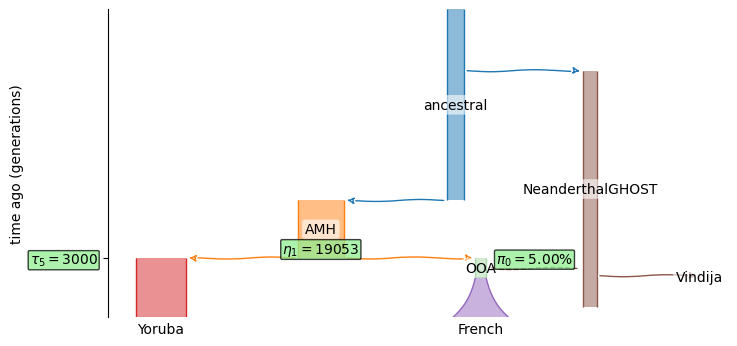

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), sharey=True)
params.tubes(True, True, hide_non_inferreds=True, 
             tau_keys=['tau_5'], ax=ax)
plt.savefig(f"{dissertation_dir}figures/chapter3/demo/3poparc.pdf", format="pdf", bbox_inches="tight", dpi=600)

In [48]:
def ftime():
    momi.negative_loglik_with_gradient(params, jsfs)

In [49]:
from timeit import repeat

In [50]:
comp_times = {}
runtimes = {}

In [51]:
no_sampler_times = repeat(ftime, repeat=11, number=1)

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/math_functions.py:14: UserWarning: Explicitly requested dtype float requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x = jnp.array(x, dtype='float')


In [52]:
comp_times['No Sampler'] = no_sampler_times[0]
runtimes['No Sampler'] = np.mean(no_sampler_times[1:])

# Bound Sampler

In [74]:
caption = "Bound Sampler Runtime"
tlabel = 'tbl:ch3:bs_runtimes'

In [75]:
def get_momi_b(q):
    momi_b = Momi(demo, sampled_demes, sample_sizes, jitted=True)
    bounds = momi_b.bound_sampler(params, 10000, min_lineages=2, seed=108, quantile=q)
    momi_b = momi_b.bound(bounds)
    return momi_b

In [81]:
for q in [0.95, 0.99, 0.999, 1.0]:
    momi_b = get_momi_b(q)
    def ftime():
        momi_b.negative_loglik_with_gradient(params, jsfs)
        
    times = repeat(ftime, repeat=11, number=1)
    comp_times[str(q)] = times[0]
    runtimes[str(q)] = np.mean(times[1:])

In [82]:
dbs = pd.DataFrame([pd.Series(comp_times), pd.Series(runtimes)]).T
dbs = dbs.reindex(['No Sampler', '1.0', '0.999', '0.99', '0.95'])
dbs = dbs.style.format('{:.3f}').to_latex()

In [83]:
split_line = '\\\\\n'

In [84]:
x = dbs.split(split_line)
x[0] = '\\begin{tabular}{l|rr}\n\\bfseries Percentile & \\bfseries Compilation Time & \\bfseries Runtime $\\nabla\ell$'
x[1] = '\hline\hline\n' + x[1] 
x = split_line.join(x)
x = add_captions(x, caption, tlabel)

In [85]:
print(x)

\begin{table}
\caption{Bound Sampler Runtime}
\label{tbl:ch3:bs_runtimes}
\begin{scriptsize}
\begin{center}

\begin{tabular}{l|rr}
\bfseries Percentile & \bfseries Compilation Time & \bfseries Runtime $\nabla\ell$\\
\hline\hline
No Sampler & 26.283 & 3.144 \\
1.0 & 4.398 & 0.067 \\
0.999 & 4.397 & 0.052 \\
0.99 & 4.341 & 0.046 \\
0.95 & 4.320 & 0.044 \\
\end{tabular}

\end{center}
\end{scriptsize}
\end{table}
    


In [86]:
text_file = open(f"{dissertation_dir}tables/bs_timing.tex", "w")
n = text_file.write(x)
text_file.close()